In [1]:
# I - : Importing  the library and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
from keras.models import Sequential,load_model
from keras.layers import Dropout,Dense,LSTM, GRU,Bidirectional,Conv1D,MaxPooling1D,GlobalMaxPooling1D
#from tensorflow.keras import Input,layers
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,make_scorer

In [2]:
# II - : Importing the training set
dataset=pd.read_csv("https://raw.githubusercontent.com/oreilly-mlsec/book-resources/599669c7124dffb65ea7f6e0b7626df32496b1d6/chapter3/datasets/cpu-utilization/cpu-full-b.csv", sep=",")

In [3]:
# III -  split of data Test & Training

# III.1 - : Size the data Test, Training
train_size=int(len(dataset)*.85)
test_size=int(len(dataset)*.15)
x_trainning,x_testing=dataset.iloc[0:train_size],dataset.iloc[(train_size+1):(train_size+test_size)]

In [4]:
# III.3 - : Preparing data for timesteps (lags)

def normalisationPreparationDonnee(data,lags):
    data=data['cpu'].values
    sc = MinMaxScaler(feature_range = (0, 1))
    #sc=StandardScaler()
    data1= data.reshape(-1,1)
    data2 = sc.fit_transform(data1)
    def preparation_data():
        x_train = []
        y_train = []
        for i in range(lags,len(data2)):
            x_train.append(data2[i-lags:i, 0])
            y_train.append(data2[i, 0])
        return np.array(x_train), np.array(y_train)
    x_train, y_train = preparation_data()
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train


In [5]:
# IV - TRAINING OF DIFFERENTS MODELS

lags=5

x_train, y_train = normalisationPreparationDonnee(x_trainning, lags)
x_test, y_test = normalisationPreparationDonnee(x_testing, lags)


In [6]:
# IV.6 - : Training of the hybrid model ConvNet1D - Bidirectional

#IV.6.1 - : Initialising of model hybrid ConvNet1D-Bidirectional


# Training of model - # forme (samples,time,features)
start=time()
modelConvNet1DBidirect = Sequential()
modelConvNet1DBidirect.add(Conv1D(100, kernel_size=1,activation='tanh',input_shape=(x_train.shape[1], 1)))
modelConvNet1DBidirect.add(Conv1D(128, kernel_size=1,activation='tanh'))
modelConvNet1DBidirect.add(MaxPooling1D(pool_size=2,strides=1,padding='same'))
modelConvNet1DBidirect.add(Conv1D(64, kernel_size=1,activation='tanh'))
modelConvNet1DBidirect.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
modelConvNet1DBidirect.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
modelConvNet1DBidirect.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
modelConvNet1DBidirect.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
modelConvNet1DBidirect.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
modelConvNet1DBidirect.add(Bidirectional(LSTM(units = 100)))
modelConvNet1DBidirect.add(Dense(units = 1))
modelConvNet1DBidirect.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
              metrics=['accuracy'])

historyConvNet1DBidirect=modelConvNet1DBidirect.fit(x_train, y_train, 
                                                    epochs = 500, batch_size = 5,
                                                    validation_split=0.20,verbose=0)

elapsed=time()-start
print(modelConvNet1DBidirect.summary())
print('duree totale est de :',elapsed/60)
# 36 minutes


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 100)            200       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            12928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 64)             8256      
_________________________________________________________________
bidirectional (Bidirectional (None, 5, 256)            197632    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 5, 128)            164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 64)             4

In [7]:
# IV.6.2 - :  Saving and importing the model
#modelConvNet1DBidirect.save('modelConvNet1DBidirectProj.h5') 
#creates a HDF5 file 'my_model.h5' et model = load_model('modelRnnLSTMProjetSecurite.h5')
# pour le detruire del model  # deletes the existing model
#modelConvNet1DBidirect = load_model('modelConvNet1DBidirectProj.h5')

In [8]:
#  IV.1.4 - : Calculating Errors and Viewing Model Fits
# on Training and Test data(identical reference for all methods)

def ErreurPrediction(Nommodele,data,prediction ):
    print('La R^2-Squared(r2_score) du modèle {} est : {}'.format(Nommodele,r2_score(data,prediction)))
    print('La MAE modèle {} est de: {} '.format(Nommodele,mean_absolute_error(data,prediction)))
    print('La MSE modèle {} est de: {} '.format(Nommodele,mean_squared_error(data,prediction)))
    print('RMSE est:{}'.format(np.sqrt(mean_squared_error(data,prediction))))
   

def LossAccuracy(nomDonnées,modelLSTM,x_test,y_test):
    score = modelLSTM.evaluate(x_test, y_test,verbose=0)
    erreur=modelLSTM.metrics_names
    print('Les pertes sur les données {} sont: '.format(nomDonnées))
    print("%s: %.2f%%" % (erreur[0], score[0]*100))
    print("%s: %.2f%%" % (erreur[1], score[1]*100))


#  IV.1.5 - : Viewing two-by-two graphs

def Affichage(historylstm,modelLSTM,Nommodele):
    y_pred_train=modelLSTM.predict(x_train)
    y_pred_test=modelLSTM.predict(x_test)
    plt.figure(figsize=(18,10))
    plt.subplot(1,3,1)
    plt.plot(historylstm.history['loss'],'b',label='Entrainement')
    plt.plot(historylstm.history['val_loss'],'green',label='Validation')
    plt.title('Perte Modèle {}'.format(Nommodele))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrainement', 'Validation'], loc='upper left')
    plt.subplot(1,3,2)
    plt.plot(y_train, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_train, color = 'blue', label = 'Prédiction du modèle {}'.format(Nommodele))
    plt.title('Modèle {} : Data training'.format(Nommodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(y_test, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_test, color = 'blue', label = 'Prédiction du modèle {} '.format(Nommodele))
    plt.title('Modèle {} :Data test'.format(Nommodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    
def Affichage_Model(modelLSTM,NomDumodele):
    y_pred_train=modelLSTM.predict(x_train)
    y_pred_test=modelLSTM.predict(x_test)
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.plot(y_train, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_train, color = 'blue', label = 'Prédiction du modèle {}'.format(NomDumodele))
    plt.title('Modèle {} : Data training'.format(NomDumodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(y_test, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_test, color = 'blue', label = 'Prédiction du modèle {} '.format(NomDumodele))
    plt.title('Modèle {} :Data Test'.format(NomDumodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()

La R^2-Squared(r2_score) du modèle Erreur données Entrainement est : 0.9736102842937034
La MAE modèle Erreur données Entrainement est de: 0.020207619886710257 
La MSE modèle Erreur données Entrainement est de: 0.0016373369164838364 
RMSE est:0.04046402002376724
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.7984868711111166
La MAE modèle Erreur données test est de: 0.08749098110766636 
La MSE modèle Erreur données test est de: 0.0156693158107919 
RMSE est:0.1251771377320631
Les pertes sur les données enrainement sont: 
loss: 0.16%
accuracy: 0.54%
Les pertes sur les données Test sont: 
loss: 1.57%
accuracy: 5.38%


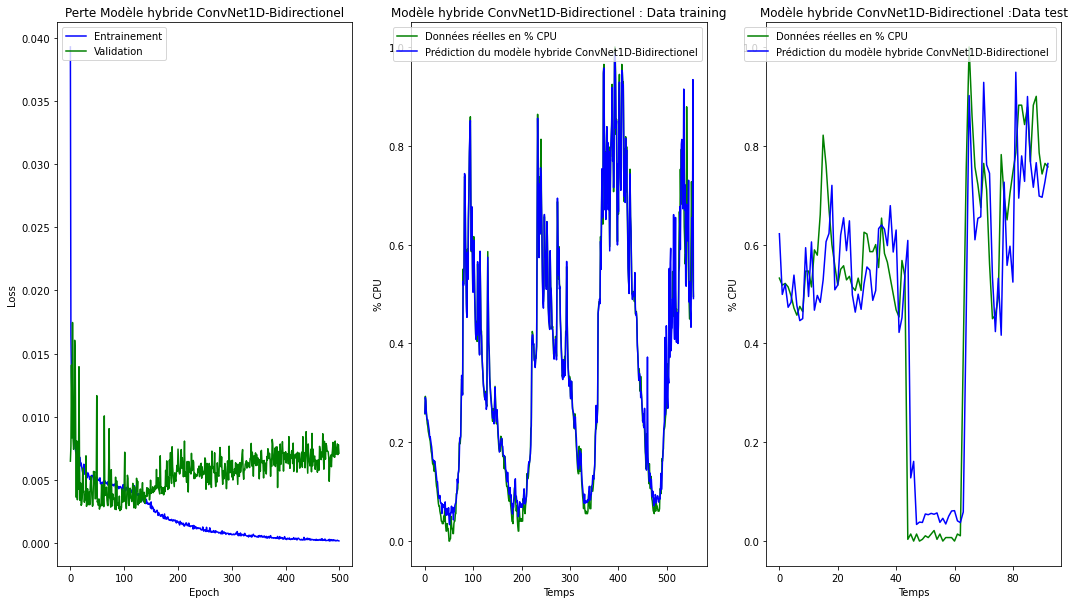

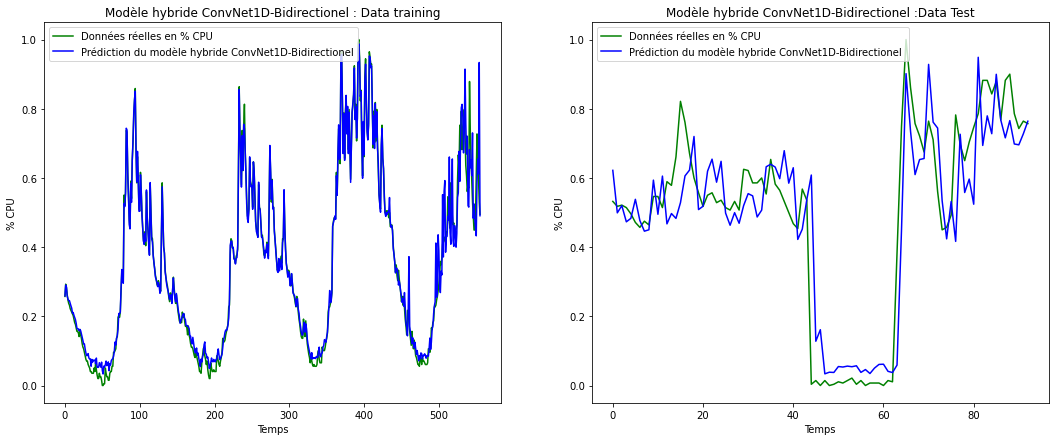

In [9]:
# IV.6.3 - : Calculation of errors & Plot training & validation accuracy values

ErreurPrediction("Erreur données Entrainement",y_train,modelConvNet1DBidirect.predict(x_train))
ErreurPrediction("Erreur données test",y_test,modelConvNet1DBidirect.predict(x_test))

LossAccuracy("enrainement",modelConvNet1DBidirect,x_train,y_train)
LossAccuracy("Test", modelConvNet1DBidirect,x_test,y_test)
Affichage(historyConvNet1DBidirect,modelConvNet1DBidirect,"hybride ConvNet1D-Bidirectionel")
Affichage_Model(modelConvNet1DBidirect,"hybride ConvNet1D-Bidirectionel")